## Loss Functions, Optimizers, & The Training Loop

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [219]:
import math
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.nn import init
from torch import tensor

In [4]:
from fastai import datasets

In [5]:
def get_data(MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'):
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((X_train, y_train), (X_val, y_val), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (X_train, y_train, X_val, y_val))

def normalize(x, m, s):
    return (x-m)/s

In [6]:
torch.nn.modules.conv._ConvNd.reset_parameters??

Signature: torch.nn.modules.conv._ConvNd.reset_parameters(self)
Docstring: <no docstring>
Source:   
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
File:      /opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py
Type:      function


In [7]:
X_train, y_train, X_test, y_test = get_data()

In [8]:
train_mean, train_std = X_train.mean(), X_train.std()

In [9]:
X_train = normalize(X_train, train_mean, train_std)
X_test = normalize(X_test, train_mean, train_std)

In [10]:
X_train = X_train.view(-1, 1, 28, 28)
X_test = X_test.view(-1, 1, 28, 28)
X_train.shape, X_test.shape

(torch.Size([50000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [11]:
n = X_train.shape[0]
c = y_test.max() + 1
nh = 32
n, c

(50000, tensor(10))

Let's create a `Conv2d` layer:

In [12]:
l1 = nn.Conv2d(in_channels=1, out_channels=nh, kernel_size=5)

In [13]:
x = X_test[:100]
y = y_test[:100]
x.shape, y.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [14]:
def stats(x):
    return x.mean(), x.std()

In [15]:
stats(l1.weight), stats(l1.bias)

((tensor(0.0072, grad_fn=<MeanBackward0>),
  tensor(0.1143, grad_fn=<StdBackward0>)),
 (tensor(0.0028, grad_fn=<MeanBackward0>),
  tensor(0.1193, grad_fn=<StdBackward0>)))

Let's check the output:

In [16]:
t = l1(x)

In [17]:
stats(t)

(tensor(0.0204, grad_fn=<MeanBackward0>),
 tensor(0.6779, grad_fn=<StdBackward0>))

We would like the outputs to have a mean of 0 and a standard deviation of 1. The mean is fine but the standard diviation is not quite there.

Let's compare this to the normal Kaiming init with a leak of 1 because we're not using an activation function, remember:

$$LeakyReLU(x,\alpha)=\begin{cases}
x,  & \text{if $x \ge 0$} \\
\alpha x, & \text{if $x < 0$}
\end{cases}$$

When we switch to a normal kiming initialization with $a=1$, we get an output with $\mu \approx 0$ and $\sigma \approx 1$. So far so good.

Let's define `LeakyReLU` which defaults to `ReLU`:

In [18]:
def f1(x, a=0):
    return F.leaky_relu(l1(x), a)

In [19]:
init.kaiming_normal_(l1.weight, a=0)
stats(f1(x))

(tensor(0.4913, grad_fn=<MeanBackward0>),
 tensor(0.9505, grad_fn=<StdBackward0>))

Due to the relu function, the mean is no longer 0, it shifts to $\approx 1/2$

Let's go back to look at how the `Conv2d` layer handle's it:

In [20]:
l1 = nn.Conv2d(1, nh, 5)

In [21]:
stats(f1(x))

(tensor(0.1978, grad_fn=<MeanBackward0>),
 tensor(0.4152, grad_fn=<StdBackward0>))

In [22]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

In [23]:
rec_fs = l1.weight[0,0].numel()
rec_fs

25

In [24]:
nf, ni, *_ = l1.weight.shape
nf, ni

(32, 1)

Let's calculate the number of projections (mappings) **in** and **out**:

In [25]:
fan_in = ni * rec_fs
fan_out = nf * rec_fs
fan_in, fan_out

(25, 800)

In [26]:
def gain(a):
    """Calculates the gain for LeakyReLUs"""
    return math.sqrt(2.0 / (1 + a**2))

In [27]:
gain(1), gain(0), gain(0.01), gain(0.1), gain(math.sqrt(5.))

(1.0,
 1.4142135623730951,
 1.4141428569978354,
 1.4071950894605838,
 0.5773502691896257)

One thing we should remember is that the PyTorch team uses Kaiming **uniform** and not Kaiming **normal**, which have different $\sigma$ dynamics.

We want to know what is the standard deviation of a uniform distribution between $[-1,1]$: 

In [28]:
torch.zeros(10000).uniform_(-1, 1).std()

tensor(0.5741)

In [29]:
1/math.sqrt(3.)

0.5773502691896258

It seems that the PyTorch team wanted the gain to handle uniform random numbers instead of settling on normal distributions (but still doesn't fully work).

Let's implement our own version of kaiming:

In [30]:
def kaiming2(x, a, use_fan_out=False):
    nf, ni, *_ = x.shape
    rec_fs = x[0,0].shape.numel()
    fan = nf * rec_fs if use_fan_out else ni * rec_fs
    std = gain(a) / math.sqrt(fan)
    bound = math.sqrt(3.) * std
    x.data.uniform_(-bound, bound)

In [31]:
kaiming2(l1.weight, a=0);
stats(f1(x))

(tensor(0.4499, grad_fn=<MeanBackward0>),
 tensor(0.8254, grad_fn=<StdBackward0>))

This is good, let's showcase what PyTorch's default does:

In [32]:
kaiming2(l1.weight, a=math.sqrt(5.));
stats(f1(x))

(tensor(0.2158, grad_fn=<MeanBackward0>),
 tensor(0.4061, grad_fn=<StdBackward0>))

Let's take a look at a final distribution's variance after multiple convolutional layers:

In [33]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(-1)

In [34]:
m = nn.Sequential(
    nn.Conv2d(1, 8, 5, stride=2, padding=2), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(32, 1, 3, stride=2, padding=1),
    nn.AdaptiveAvgPool2d(output_size=1),
    Flatten(),
)

In [35]:
t = m(x)
stats(t)

(tensor(0.0089, grad_fn=<MeanBackward0>),
 tensor(0.0106, grad_fn=<StdBackward0>))

This looks like a really big problem, the variance kept decrease from a standard deviation of 1 in the input layer to 0 in the final layer.

Let's take a look at what happens for the loss:

In [36]:
def mse(output, targ):
    return (output.squeeze(-1) - targ).pow(2).mean()

In [37]:
l = mse(t, y)

In [38]:
l.backward()

In [39]:
# stats on the gradients
stats(m[0].weight.grad)

(tensor(-0.0235), tensor(0.0407))

Let's now verify Kaiming uniform with $a=0$:

In [40]:
init.kaiming_uniform_??

Signature:
init.kaiming_uniform_(
    tensor,
    a=0,
    mode='fan_in',
    nonlinearity='leaky_relu',
)
Source:   
def kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    uniform distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{U}(-\text{bound}, \text{bound})` where

    .. math::
        \text{bound} = \sqrt{\frac{6}{(1 + a^2) \times \text{fan\_in}}}

    Also known as He initialization.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        a: the negative slope of the rectifier used after this layer (0 for ReLU
            by default)
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
      

In [41]:
for l in m:
    if isinstance(l, nn.Conv2d):
        init.kaiming_uniform_(l.weight)
        l.bias.data.zero_()

In [42]:
t = m(x)
stats(t)

(tensor(0.8572, grad_fn=<MeanBackward0>),
 tensor(0.3599, grad_fn=<StdBackward0>))

This is better (after directly using `kaiming_uniform_` and not `reset_parameters`).

Let's check the loss:

In [43]:
l = mse(t, y)

In [44]:
l.backward()

In [45]:
# stats on the gradients
stats(m[0].weight.grad)

(tensor(0.0487), tensor(0.8328))

---

## Why you Need a Good Init

To understand why initialization is so important, let's focus on the main NN operation: Matrix Multiplication.

So let's just take a vector `x` and a matrix `a` and multiply them a 100 times (as if we had 100 layers):

In [46]:
x = torch.randn(512)
a = torch.randn(512, 512)

In [47]:
for i in range(100):
    x = a @ x

In [50]:
x.mean(), x.std()

(tensor(nan), tensor(nan))

This is activation explosion, we can even ask the loop to break when that happens:

In [51]:
x = torch.randn(512)
a = torch.randn(512, 512)

In [54]:
for i in range(100):
    x = a @ x
    if x.std() != x.std():
        break

In [55]:
i

28

On the other hand, If you initialize your activations with a scale that is very low, you'll get another problem:

In [56]:
x = torch.randn(512)
a = torch.randn(512, 512) * 0.01

In [57]:
for i in range(100):
    x = a @ x

In [58]:
x.mean(), x.std()

(tensor(0.), tensor(0.))

The problem is clear now, you can't really randomly initialize the weights of each layer, you have to be careful in the way you initialize them.

People have came up with several ways to initialize their weight matrices, examples:

- Use a standard deviation that makes sure that $X$ and $AX$ are exactly the same scale.
- Use an orthogonal matrix to initialize the weights
    - They preserve the $L_{2}$ norm
        - $X$ and $AX$ would have the same sum of squares.
- Use spectral normalization on the matrix A
    - The spectral norm of $A$ is the least possible number $M$ such that: `torch.norm(A@X) <= M*torch.norm(X)`
        - So dividing $A$ by $M$ insures you don't overflow.
            - But you can still vanish with this.
.. continue with the notebook from course-v3 if you're interested in initialization (Jeremy stops here).

---

In [102]:
from torchy.session_one import *

In [81]:
X_train, y_train, X_val, y_val = get_data()

In [82]:
m, n = X_train.shape
c = y_train.max() + 1
nh = 50

In [83]:
model = Model(n_in=n, nh=nh, n_out=10)

In [84]:
pred = model(X_train)

### Cross-Entropy Loss

First we need to compute the softmax of our activations, defined by:

$$softmax(x)_{i}=\frac{e^{x_i}}{\sum_{0 \le j \le n}e^{x_{j}}}$$

In practice, wee need the log of the softmax to calculate the loss, because cross entropy is expressed as follows:

$$J(\Theta)=-\sum_{i}y_{i}log(\hat{p}_{i})$$

In [87]:
def log_softmax(x):
    return (x.exp()/x.exp().sum(-1, keepdim=True)).log()

In [88]:
sm_pred = log_softmax(pred)

But since our $y_{i}$ are one-hot encoded, this can be written as $-log(p_{i})$ where $i$ is the index of the desired target.

Let's exploit a trick to avoid multiplying a bunch of zeros:

In [90]:
y_train[:3]

tensor([5, 0, 4])

In [94]:
sm_pred[0][5]

tensor(-2.3326, grad_fn=<SelectBackward>)

Let's use advanced indexing:

In [95]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.3326, -2.4772, -2.3288], grad_fn=<IndexBackward>)

In [96]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [97]:
loss = nll(sm_pred, y_train)

In [98]:
loss

tensor(2.3119, grad_fn=<NegBackward>)

Let's further simplify the `log_softmax` function using:

$$log(\frac{a}{b})=log(a)-log(b)$$

In [99]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [103]:
test_near(nll(log_softmax(pred), y_train), loss)

The further you go away from zero, the less precise a computer will be, so let's use the `LogSumExp` Trick to get more stable output values:

$$log(\sum_{j=1}^{n}e^{x_j})=a+log(\sum_{j=1}^{n}e^{x_{j}-a}); \space a=max\{x_{j}\}$$

In [104]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us.

In [105]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our softmax function:

In [106]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [107]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [109]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [110]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic Training Loop

In [111]:
loss_func = F.cross_entropy

In [112]:
def accuracy(out, yb):
    return (torch.argmax(out, dim=1) == yb).float().mean()

In [113]:
bs = 64
xb = X_train[0:bs]  # A mini-batch from the training data set
preds = model(xb)
preds[0], preds.shape

(tensor([-0.3100, -0.1636, -0.1020,  0.1130,  0.0021, -0.0736, -0.0322,  0.0427,
          0.1139, -0.0998], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [114]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3198, grad_fn=<NllLossBackward>)

In [115]:
accuracy(preds, yb)

tensor(0.1250)

In [155]:
lr = 0.1  # learning rate
epochs = 5  # how many epochs to train for?

In [121]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):  # a mini-batch at a time.
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [124]:
loss_func(model(X_train), y_train), accuracy(model(X_train), y_train)

(tensor(0.6914, grad_fn=<NllLossBackward>), tensor(0.7849))

### Using parameters & optim

#### Parameters

Use `nn.Module.__setattr__` and move `relu` to functional:

In [156]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [157]:
model = Model(n_in=n, nh=nh, n_out=10)

In [158]:
for name, layer in model.named_children():
    print(f'{name}: {layer}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [159]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [160]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

Let's reduce our training loop using PyTorch inner parameter updates:

In [166]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = X_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [167]:
fit()

In [168]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2464, grad_fn=<NllLossBackward>), tensor(0.9375))

#### Registering Modules

We can use the original `layers` approach, but we have to register the modules:

In [169]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10)]

In [175]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, layer in enumerate(self.layers):
            self.add_module(f'layer_{i}', layer)
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [176]:
model = Model(layers)

In [177]:
model

Model(
  (layer_0): Linear(in_features=50000, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

But this is kind of clunky so let's use `nn.ModuleList`

### nn.ModuleList

In [178]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [179]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=50000, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

This also is a bit clunky, and surprisingly, we have `nn.Sequential`:

### nn.Sequential

In [180]:
model = nn.Sequential(nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, 10))

In [181]:
fit()

In [182]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.6552, grad_fn=<NllLossBackward>), tensor(0.9062))

In [183]:
nn.Sequential??

Init signature: nn.Sequential(*args)
Source:        
class Sequential(Module):
    r"""A sequential container.
    Modules will be added to it in the order they are passed in the constructor.
    Alternatively, an ordered dict of modules can also be passed in.

    To make it easier to understand, here is a small example::

        # Example of using Sequential
        model = nn.Sequential(
                  nn.Conv2d(1,20,5),
                  nn.ReLU(),
                  nn.Conv2d(20,64,5),
                  nn.ReLU()
                )

        # Example of using Sequential with OrderedDict
        model = nn.Sequential(OrderedDict([
                  ('conv1', nn.Conv2d(1,20,5)),
                  ('relu1', nn.ReLU()),
                  ('conv2', nn.Conv2d(20,64,5)),
                  ('relu2', nn.ReLU())
                ]))
    """

    def __init__(self, *args):
        super(Sequential, self).__init__()
        if len(args) == 1 and isinstance(args[0], OrderedDict):
            

### optim

Let's replace our previously manually coded optimization step, and instead use just:

```Python
opt.step()
opt.zero_grad()
```

In [184]:
class Optimizer():
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= lr * p.grad
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [185]:
model = nn.Sequential(nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, 10))

In [187]:
opt = Optimizer(model.parameters(), lr=0.5)

In [188]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [189]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.6713, grad_fn=<NllLossBackward>), tensor(0.9062))

PyTorch already provides this exact functionality in `optim.SGD`:

In [190]:
from torch import optim

In [191]:
optim.SGD.step??

Signature: optim.SGD.step(self, closure=None)
Source:   
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['mome

If we remove all of the other options, we end up with the same formulation we implemented earlier.

In [192]:
def get_model():
    model = nn.Sequential(nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [193]:
model, opt = get_model()

In [194]:
loss_func(model(xb), yb)

tensor(2.3403, grad_fn=<NllLossBackward>)

In [195]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [196]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.6599, grad_fn=<NllLossBackward>), tensor(0.9062))

Randomized tests can be very useful:

In [198]:
assert acc>0.7

Never fix the random seed until you finish all your experiments and you want a reproducibility state. You do this because It's beneficial for you to notice the variability within you model/generators/..

## Dataset & DataLoader

### Dataset

It's clunky to iterate over X,y mini-batche values separately. Instead let's do these two steps together, introducing the `Dataset` class: 

In [202]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [203]:
train_ds, valid_ds = Dataset(X_train, y_train), Dataset(X_val, y_val)
assert len(train_ds) == len(X_train)
assert len(valid_ds) == len(X_val)

In [204]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)

In [207]:
model, opt = get_model()

In [212]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs:i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [213]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.2641, grad_fn=<NllLossBackward>), tensor(0.9219))

### DataLoader

Let's make the way we loop much cleaner, using the DataLoader:

In [214]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [215]:
train_dl = DataLoader(train_ds, bs)
val_dl = DataLoader(valid_ds, bs)

In [217]:
xb, yb = next(iter(val_dl))
assert xb.shape==(bs, 28*28)
assert yb.shape==(bs,)

tensor(3)

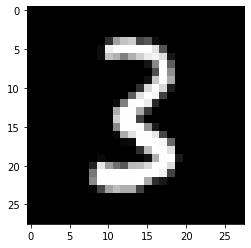

In [222]:
plt.imshow(xb[0].view(28,28), cmap='gray')
yb[0]

In [223]:
model, opt = get_model()

In [314]:
def fit(epochs=1):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [227]:
fit()

In [228]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0161, grad_fn=<NllLossBackward>), tensor(1.))

In [229]:
assert acc > 0.7

Code in a way that you can read and understand the final version in simple english.

## Random Shuffling

We want our training set to be in random order, and that order should differ at each iteration. But the validation set shouldn't be randomized.

In [266]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.m, self.bs, self.shuffle = len(ds), bs, shuffle
    
    def __iter__(self):
        if self.shuffle:
            self.idxs = torch.randperm(self.m)
        else:
            self.idxs = torch.arange(self.m)
        for i in range(0, self.m, self.bs):
            yield self.idxs[i:i+self.bs]

In [267]:
small_ds = Dataset(*train_ds[:10])

In [268]:
s = Sampler(small_ds, 3, shuffle=True)

In [269]:
[o for o in s]

[tensor([1, 3, 4]), tensor([0, 9, 2]), tensor([8, 5, 6]), tensor([7])]

In [270]:
s = Sampler(small_ds, 3, shuffle=False)

In [271]:
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

Now we use the sampler in our data loader:

In [272]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [273]:
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

Let's create the new samplers and dataloaders:

In [274]:
train_samp = Sampler(train_ds, bs=bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs=bs, shuffle=False)

In [275]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

In [293]:
xb, yb = next(iter(valid_dl))

tensor(3)

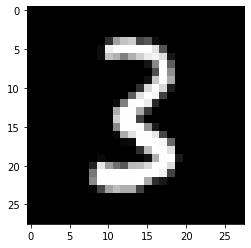

In [294]:
plt.imshow(xb[0].reshape(28,28), cmap='gray')
yb[0]

In [296]:
xb, yb = next(iter(train_dl))

tensor(8)

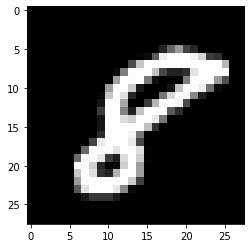

In [297]:
plt.imshow(xb[0].reshape(28,28), cmap='gray')
yb[0]

In [298]:
model, opt = get_model()
fit()

In [299]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0536, grad_fn=<NllLossBackward>), tensor(0.9844))

In [300]:
assert acc > 0.7

### PyTorch DataLoader

In [301]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [302]:
train_dl = DataLoader(train_ds, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [303]:
xb, yb = next(iter(valid_dl))

tensor(3)

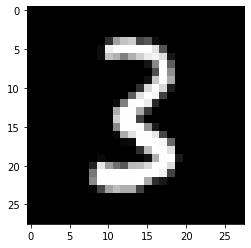

In [304]:
plt.imshow(xb[0].reshape(28,28), cmap='gray')
yb[0]

In [307]:
xb, yb = next(iter(train_dl))

tensor(0)

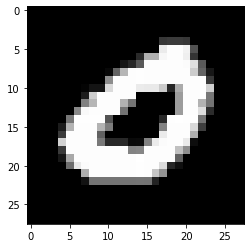

In [308]:
plt.imshow(xb[0].reshape(28,28), cmap='gray')
yb[0]

In [315]:
model, opt = get_model()

In [316]:
fit()

In [317]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0128, grad_fn=<NllLossBackward>), tensor(1.))

In [318]:
assert acc > 0.7

PyTorch defaults work fine for most things however:

In [319]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [320]:
model, opt = get_model()

In [321]:
fit()

In [322]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.0003, grad_fn=<NllLossBackward>), tensor(1.))

In [323]:
assert acc > 0.7

Note that for the PyTorch `DataLoader`, if you pass `num_workers`, it will use multiple threads to call your `Dataset`.  

## Validation

You should always have a validation set in order to know if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

In [325]:
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()  # to activate layers like batchNorm and Dropout
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in val_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [326]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    """Returns the dataloaders for both the training and validation sets"""
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now the whole process of getting the data loader and training the model can be done in 3 lines of code:

In [327]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)

In [328]:
model, opt = get_model()

In [330]:
loss, acc = fit(1, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2712) tensor(0.9236)


In [331]:
assert acc > 0.9

--- 

### Infinitely Customizable Training Loops

- Usually, we write a new training loop for every task.
- Or try to write something that incorporate everything you can think of.
- Fortunately, there is a way around this: **Callbacks**
- It's then easy to mix and match these blocks together.
    - `fastai` uses callbacks to structure new compute blocks and incorporate them in architectures and algorithms.

---

# DataBunch/Learner

In [332]:
X_train, y_train, X_val, y_val = get_data()

In [333]:
train_ds, val_ds = Dataset(X_train, y_train), Dataset(X_val, y_val)

In [334]:
nh, bs = 50, 64

In [368]:
c = int(y_train.max() + 1)

In [369]:
loss_func = F.cross_entropy

There are a lot of benefits of packaging stuff together and a function shouldn't have a lot of parameters.

Here is the signature of the fit function:

```Python
fit(epochs, model, loss_func, opt, train_dl, valid_dl)
```

Conceptually, `train_dl` & `valid_dl` should be together, then everything except `epochs` should be together into `Learner`, let's start with what we call a `DataBunch`:

In [370]:
class DataBunch():
    def __init__(self, train_dl, val_dl, c=None):
        self.train_dl, self.val_dl, self.c = train_dl, val_dl, c
    
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.val_dl.dataset

In [371]:
data = DataBunch(*get_dls(train_ds, val_ds, bs=64), c)

In [372]:
def get_model(data, lr=0.5, nh=50):
    n = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

In [373]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [374]:
learn = Learner(*get_model(data), loss_func, data)

Let's inject the learner into the fit function:

In [384]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb, yb in learn.data.train_dl:
            loss = learn.loss_func(model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
        
        learn.model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in learn.data.val_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [385]:
loss, acc = fit(5, learn)

0 tensor(2.3165) tensor(0.1142)
1 tensor(2.3165) tensor(0.1142)
2 tensor(2.3165) tensor(0.1142)
3 tensor(2.3165) tensor(0.1142)
4 tensor(2.3165) tensor(0.1142)
